## Model-agnostic Explanations

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

In [7]:
# Ensure 'lime' is available. If missing, install it and re-import.
import sys, subprocess, importlib
try:
    import lime.lime_tabular as lime_tabular
    print('lime is already installed')
except ModuleNotFoundError:
    print("'lime' not found — installing via pip...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lime'])
    importlib.invalidate_caches()
    try:
        import lime.lime_tabular as lime_tabular
        print('Successfully installed and imported lime')
    except Exception as e:
        print('Import failed after installing lime:', e)
        raise

'lime' not found — installing via pip...
  Installing build dependencies: started
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/22.7 MB ? eta -:--:--  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.7/22.7 MB 11.8 MB/s  0:00:01 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.7/22.7 MB 11.8 MB/s  0:00:01 eta 0:00:01
  Installing build dependencies: started
  Insta


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [11]:
%pip install requests

import requests
import io
import urllib3

# Disable only the InsecureRequestWarning (the request below still skips certificate verification).
# Use verify=False only if you trust the source.
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/hr_new_job_processed.csv"
resp = requests.get(url, verify=False)
resp.raise_for_status()
job_df = pd.read_csv(io.StringIO(resp.text))

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [requests]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [requests]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
job_df.describe()

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,target
count,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000
mean,0.806056,64.380421,2.748997,9.530985,2.131568,0.029180,0.042537,0.023619,0.005557,0.045442,0.853665,0.500000
std,0.128302,59.048600,1.783676,6.733267,0.627610,0.161802,0.197495,0.147348,0.070875,0.200717,0.342167,0.500022
min,0.448000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.682000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.878000,46.000000,2.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,0.920000,88.000000,3.000000,15.000000,2.247823,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,0.949000,336.000000,7.000000,21.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**The predictive task is a straightforward binary classification task, more specifically, we want to use an employee's profile features to predict if he/she is looking for a job change or not.**

### Build a Random Forest classifier as the Black-box model

In [13]:
X = job_df.loc[:, job_df.columns != 'target']
y = job_df[['target']]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 12)

Now let's train a `Random Forest` model with the following preset arguments. If you like, you may also use hyperparameter tuning methods to tune these parameters yourself.
- `random_state = 0` as a random seed to reproduce the result
- `max_depth = 25` means the max depth of a tree should be less than 25
- `max_features = 10` means the random forest includes max 10 features
- `n_estimators = 100` means total 100 trees will be built
- `bootstrap = True` means bootstrap samples will be used to build trees

In [15]:
# Define a black-box random forest model
black_box_model = RandomForestClassifier(random_state = 123, max_depth=25, 
                             max_features=10, n_estimators=100, 
                             bootstrap=True)
# Train the model
black_box_model.fit(X_train, y_train.values.ravel())

,n_estimators,100
,criterion,'gini'
,max_depth,25
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,10
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
# make some predictions and evalute the model using AUC score:

#predicting test set
y_blackbox = black_box_model.predict(X_test)

In [17]:
metrics.roc_auc_score(y_test, y_blackbox)

0.81138669587882

* AUC score is around 0.81, which indicates the model is doing a very good job in the test dataset.

### Permutation Feature Importance

* One common way to explain a machine learning model is via finding its important features and **permutation feature importance** is a popular method to calculate feature importance.

* The basic idea of permutation feature importance is we shuffle interested feature values and make predictions using the shuffled values. 
The feature importance will be measured by calculating the difference between the prediction errors before and after permutation.

You can call `permutation_importance` with the following key arguments:
- `estimator` the model to be estimated
- `X` training data X
- `y` target labels y
- `n_repeats`, Number of times to permute a feature, each permutation generates an importance value

In [18]:
# Use permutation_importance to calculate permutation feature importances
feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=5,
                                random_state=123, n_jobs=2)

In [19]:
# take a look at the generated importance results

feature_importances.importances.shape

(11, 5)

In [20]:
feature_importances.importances

array([[0.30446594, 0.30131479, 0.3045746 , 0.30033685, 0.30500924],
       [0.15527545, 0.15299359, 0.15179833, 0.15321091, 0.1578833 ],
       [0.18265783, 0.18483103, 0.18580898, 0.18298381, 0.19124199],
       [0.15386287, 0.15092904, 0.15125503, 0.14853852, 0.15581875],
       [0.1207215 , 0.11822232, 0.11539715, 0.1169184 , 0.11583179],
       [0.00086928, 0.00076062, 0.0010866 , 0.00065196, 0.00065196],
       [0.0021732 , 0.0021732 , 0.0021732 , 0.0021732 , 0.00152124],
       [0.00141258, 0.00152124, 0.00152124, 0.0016299 , 0.00130392],
       [0.00086928, 0.00065196, 0.00076062, 0.00065196, 0.00076062],
       [0.00977942, 0.01021406, 0.00977942, 0.01086602, 0.01086602],
       [0.04770184, 0.04791916, 0.04552863, 0.04704988, 0.04802782]])

It is a `11 x 5` numpy array, 11 means we have 11 features, and 5 represents the total number of permutation times. 

For each permutation, we will have a list of importance score calculated for each feature. The value represents the portion of increased prediction errors, important features will have larger values.

In [28]:
# visualise the feature importance results
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()


/var/folders/ls/jfgzf4j13hx__mtdgv2_0xbw0000gn/T/ipykernel_2150/618297238.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


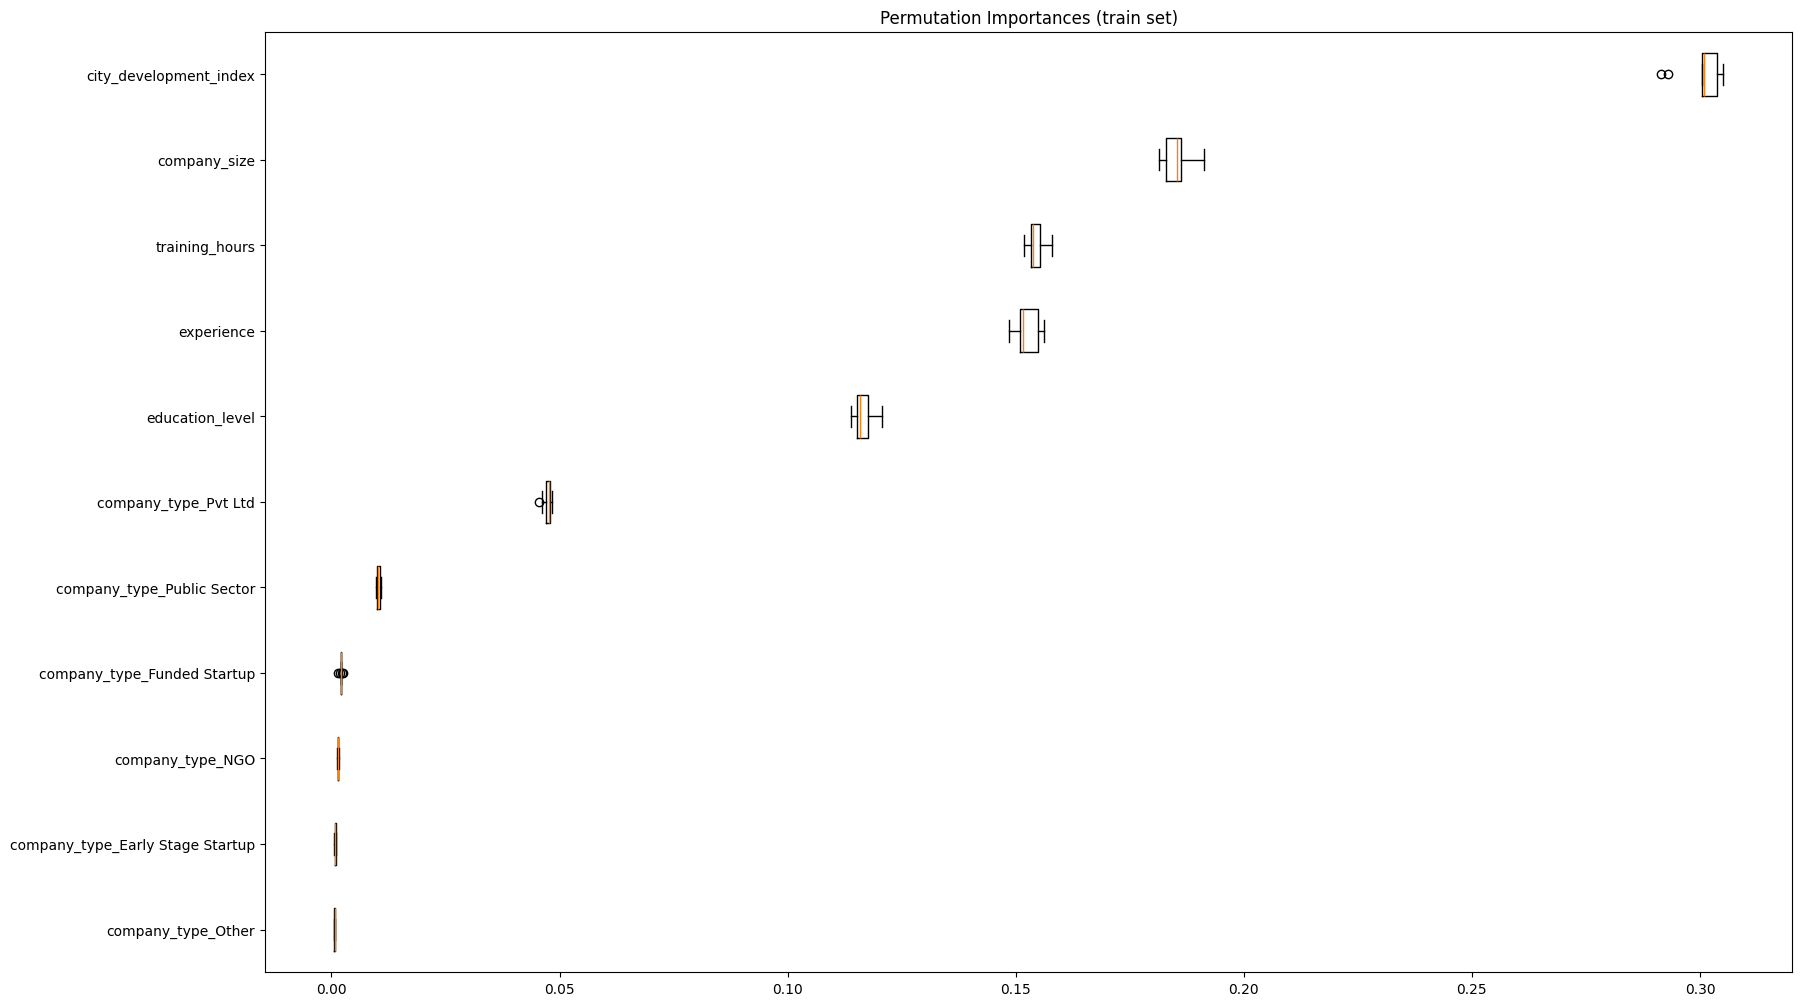

In [29]:
visualize_feature_importance(feature_importances)

Now you should see a box plot show ranked feature importances, and we can see the most important features are `city_development_index`, `company_size`, `training_hours`, `experiences`, `education_level`, and so on, and you should have a general understanding of how the black-box model determines if an employee is looking for a new job or not.

/var/folders/ls/jfgzf4j13hx__mtdgv2_0xbw0000gn/T/ipykernel_2150/618297238.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


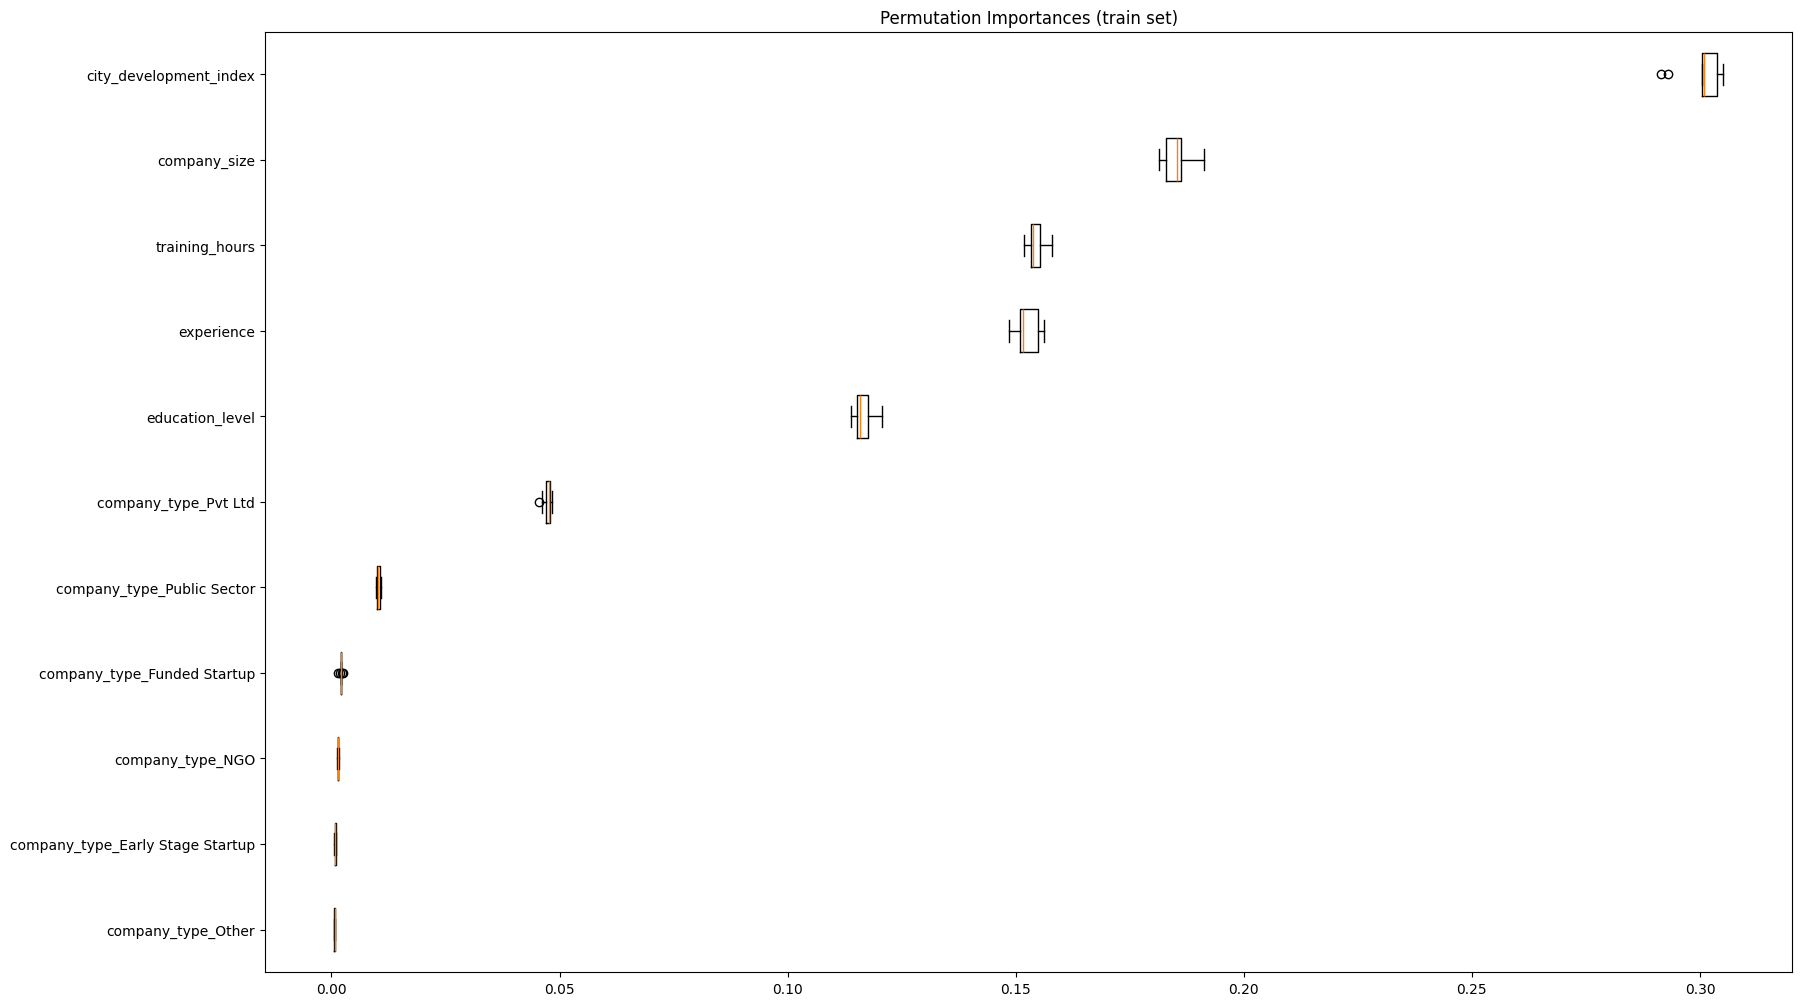

In [ ]:
# Use a different n_repeats=10 to calculate 
# and visualize feature importance values

feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=10,
                                random_state=123, n_jobs=2)

visualize_feature_importance(feature_importances)

### Partial Dependency Plot (PDP)

* Partial Dependency Plot (PDP) is an effective way to illustrate the relationship between an interested feature and the model outcome. It essentially visualizes the marginal effects of a feature, that is, shows how the model outcome changes when a specific feature changes in its distribution.

* Since a machine learning model may include many features, and it is not feasible to create PDP for every single feature. Thus, we normally first find the most important features via ranking their feature importances. Then, we can only focus PDP on those important features.

* From the previous step, we know some important features are `city_development_index`, `company_size`, `experience`, `education_level`, and we can easily create PDP for those features using `plot_partial_dependence` in `sklearn` package.

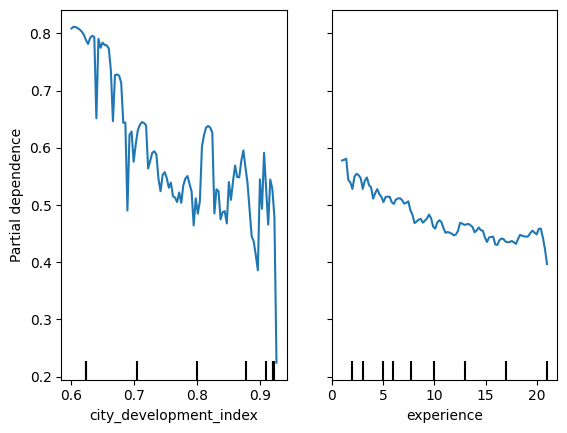

In [ ]:
# create PDP for features city_development_index, experience:

try:
    # Older sklearn versions provide plot_partial_dependence
    from sklearn.inspection import plot_partial_dependence
    plot_partial_dependence(estimator=black_box_model, 
                            X=X_train, 
                            features=important_features,
                            random_state=123)
except Exception:
    # Newer sklearn versions use PartialDependenceDisplay
    PartialDependenceDisplay.from_estimator(estimator=black_box_model,
                                            X=X_train,
                                            features=important_features,
                                            kind='average')
plt.show()

**Then you should see two PDPs are plotted for city_development_index and experience. They all have roughly negative linear relationship betweens the outcome, for example, if an employee is in a well-developed city and has a lot of experiences, then he/she is unlikely to change the current job.**